In [1]:
# imports
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
# create train_df and test_df

train_df = pd.read_csv('train_COVIDx9A.txt', sep=" ", header=None)
#Columns are added because it was seen that column names were 0,1,2,3, so new column names are added
#which are given in descriptions
train_df.columns=['patient id', 'filename', 'class', 'data source']
# Since we are doing image classification, patient id and data source is of no importance to us, so
#we cn drop them
train_df=train_df.drop(['patient id', 'data source'], axis=1 )

test_df = pd.read_csv('test_COVIDx9A.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [4]:
train_df.head()

,filename,class
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [5]:
test_df.head()

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,COVID-19
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,COVID-19
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,COVID-19
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,COVID-19
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,COVID-19


In [6]:
train_df['class'].value_counts()

COVID-19     16490
normal        8085
pneumonia     5555
Name: class, dtype: int64

In [7]:
# downsampling and suffling

covid  = train_df[train_df['class']=='COVID-19'] 
normal = train_df[train_df['class']=='normal']
pneumonia = train_df[train_df['class']=='pneumonia']
from sklearn.utils import resample
#majority class that  is negative, we need to downsample/decrease that class so that there is no bias
#n_samples = 2158 means we want 2158 sample of class negative, since there are 2158 samples of class positive
df_covid_downsampled = resample(covid, replace = True, n_samples = 5555) 
df_normal_downsampled = resample(normal, replace = True, n_samples = 5555)
#concatenate
train_df = pd.concat([pneumonia, df_covid_downsampled,df_normal_downsampled])

from sklearn.utils import shuffle
train_df = shuffle(train_df) # shuffling so that there is particular sequence

In [8]:
train_df['class'].value_counts()

COVID-19     5555
pneumonia    5555
normal       5555
Name: class, dtype: int64

In [9]:
test_df['class'].value_counts()

COVID-19     200
pneumonia    100
normal       100
Name: class, dtype: int64

In [10]:
# split a validation data

train_data, valid_data = train_test_split(train_df, train_size=0.8, random_state=0)
train_path = 'train'
test_path = 'test'

In [11]:
# get images

train_datagen = ImageDataGenerator(rescale = 1./255., shear_range = 0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_data, directory=train_path, x_col='filename', 
                                              y_col='class', target_size=(300,300), batch_size=64, 
                                               classes=['COVID-19','normal','pneumonia'])
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_data, directory=train_path, x_col='filename',
                                             y_col='class', target_size=(300,300), batch_size=64, 
                                            classes=['COVID-19','normal','pneumonia'])
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_path, x_col='filename', 
                                            y_col='class', target_size=(300,300), batch_size=32,
                                             classes=['COVID-19','normal','pneumonia'])

Found 13301 validated image filenames belonging to 3 classes.
Found 3324 validated image filenames belonging to 3 classes.
Found 400 validated image filenames belonging to 3 classes.


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 31 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 9 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
# Our base model is InceptionResNetV2, new readers are encouraged to see the architecture of this particular model
import tensorflow as tf

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape = (300,300,3),
                                                     include_top=False,classifier_activation='softmax')
for layer in base_model.layers:
    layer.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [13]:
#Now we will add some more layers to the base model for our requirements

model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    #tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = (200,200,3)),
    ##tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax')
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("covid_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', mode = "min", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_gen.classes), y = train_gen.classes)
cw = dict(zip(np.unique(train_gen.classes), weights))


In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(train_gen, class_weight = cw,
                    validation_data=valid_gen, epochs= 20, 
                    callbacks = callbacks)

Epoch 1/20
208/208 [==============================] - 2215s 11s/step - loss: 0.4002 - accuracy: 0.8479 - val_loss: 0.3751 - val_accuracy: 0.8500


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
208/208 [==============================] - 1382s 7s/step - loss: 0.2805 - accuracy: 0.8934 - val_loss: 0.2526 - val_accuracy: 0.9026
Epoch 3/20
208/208 [==============================] - 1388s 7s/step - loss: 0.2464 - accuracy: 0.9080 - val_loss: 0.3320 - val_accuracy: 0.8716
Epoch 4/20
208/208 [==============================] - 1392s 7s/step - loss: 0.2277 - accuracy: 0.9146 - val_loss: 0.2536 - val_accuracy: 0.9020

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
208/208 [==============================] - 1390s 7s/step - loss: 0.1922 - accuracy: 0.9320 - val_loss: 0.2395 - val_accuracy: 0.9095
Epoch 6/20
208/208 [==============================] - 1391s 7s/step - loss: 0.1782 - accuracy: 0.9361 - val_loss: 0.2295 - val_accuracy: 0.9167
Epoch 7/20
208/208 [==============================] - 1390s 7s/step - loss: 0.1625 - accuracy: 0.9402 - val_loss: 0.2450 - val_accuracy: 0.9101
Epoch 8/20
208/208 [==============================] - 1

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
model.load_weights('./covid_classifier_model.h5')
model.evaluate(test_gen)

13/13 [==============================] - 227s 18s/step - loss: 0.4129 - accuracy: 0.8550


[0.41287317872047424, 0.8550000190734863]

In [16]:
predictions = model.predict(test_gen)

In [17]:
test_class=np.array([])
prediction_class = np.array([])
for i in range(13):
   i, l = test_gen[i]
   test_class = np.concatenate((test_class, np.argmax(l,axis=1)))
   prediction_class = np.concatenate((prediction_class, np.argmax(model.predict(i),axis=1)))

In [18]:
cm = confusion_matrix(test_class,prediction_class)

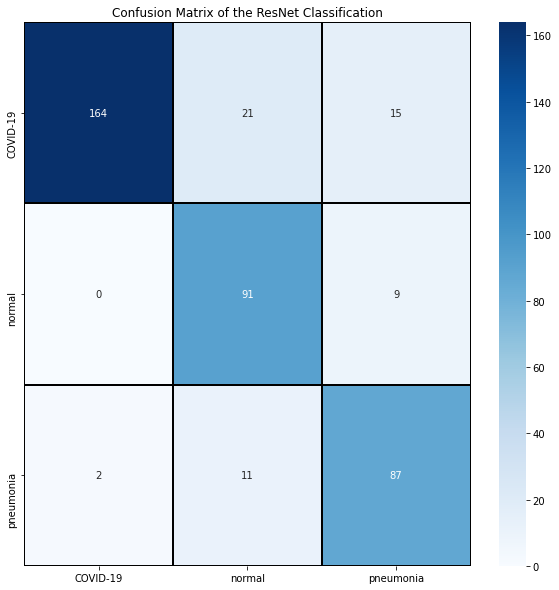

In [24]:
import seaborn as sns
cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
labels = ['COVID-19','normal','pneumonia']
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.title('Confusion Matrix of the ResNet Classification')
plt.show()

In [25]:
def plotLearningCurve(accuracy, val_accuracy, loss, val_loss, epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,accuracy,'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,val_accuracy,'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,loss,'b',label = 'Training Loss')
  ax[1].plot(epochRange,val_loss,'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

In [28]:
# recorded acc and loss
accuracy = [0.8479, 0.8934, 0.9080, 0.9146, 0.9320, 0.9361, 0.9402, 0.9436, 0.9541, 0.9586, 0.9602, 0.9674]
val_accuracy = [0.8500, 0.9026, 0.8716, 0.9020, 0.9095, 0.9167, 0.9101, 0.9026, 0.9242, 0.9218, 0.9224, 0.9215]
loss = [0.4002, 0.2805, 0.2464, 0.2277, 0.1922, 0.1782, 0.1625, 0.1535, 0.1323, 0.1206, 0.1133, 0.1003]
val_loss = [0.3751, 0.2526, 0.3320, 0.2536, 0.2395, 0.2295, 0.2450, 0.2664, 0.2215, 0.2318, 0.2268, 0.2287]

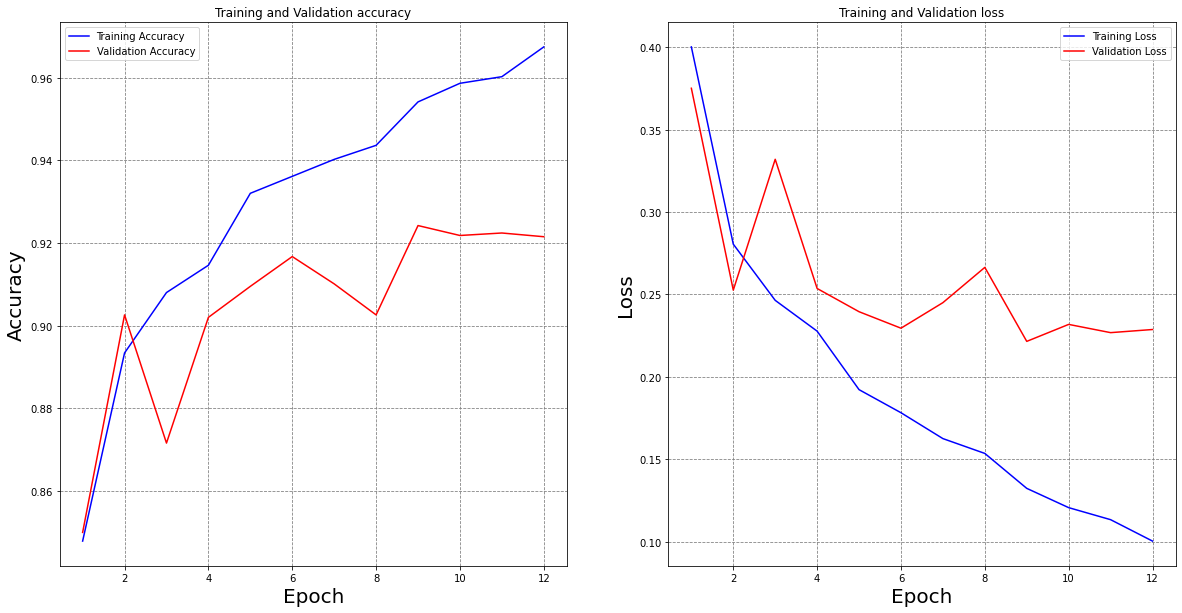

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
plotLearningCurve(accuracy, val_accuracy, loss, val_loss,12)